In [1]:
import os
import re
import json
import math
import hashlib

from tqdm import tqdm_notebook as tqdm

from collections import Counter

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
enum_role = "环节"
max_seq_len = 470

In [4]:
def cal_md5(str):
    """calculate string md5"""
    str = str.decode("utf-8", "ignore").encode("utf-8", "ignore")
    return hashlib.md5(str).hexdigest()

def text_to_sents(text):
    """text_to_sents"""
    text = text.replace("\n", " ").replace('\u3000', ' ').replace('\u0005', '').replace('\u0006', '').replace('\u0007', '').replace('\b', '').replace('■', ' ').replace('。 ', '。').replace('？ ', '？').replace('！ ', '！').replace("   ", "\n")
    results=re.compile("(https://[a-zA-Z0-9.?/&=:]*)|(http://[a-zA-Z0-9.?/&=:]*)",re.S)
    text = results.sub("",text)
    deliniter_symbols = [u"。", u"？", u"！", u"\n", u"；"]
    # paragraphs = text.split("\n")
    ret = []
    # for para in paragraphs:
    #     para += para + '\n'
    # if text == u"":
    #     continue
    sents = [u""]
    for s in text:
        sents[-1] += s
        if s in deliniter_symbols:
            sents.append(u"")
    if sents[-1] == u"":
        sents = sents[:-1]
    ret.extend(sents)
    return ret

def text_to_sents_new(text, max_seq_len = 512):
    ret = []
    start_ind = 0
    while start_ind <= len(text):
        if len(text[start_ind:]) > max_seq_len:
            sub_text = text[start_ind: start_ind + max_seq_len]
        else:
            sub_text = text[start_ind: len(text)]
        if len(ret) == 0 or ret[-1].find(sub_text) < 0:
            ret.append(sub_text)
        start_ind += max_seq_len // 2
    return ret

def marked_doc_2_sentence(doc):
    """marked_doc_2_sentence"""

    def argument_in_sent(sent, argument_list, trigger):
        """argument_in_sent"""
        trigger_start = sent.find(trigger)
        new_arguments, enum_argument = [], None
        for argument in argument_list:
            word = argument["argument"].replace("\n", " ").replace('\u3000', ' ')
            role_type = argument["role"]
            if role_type == enum_role:
                # special
                enum_argument = argument
                continue
            start = sent.find(word)
            if start < 0:
                continue
            for new_argument in new_arguments:
                if new_argument['argument_start_index'] <= start and new_argument['argument_start_index'] + len(new_argument['argument']) >= start:
                    # print("Found Same Index:")
                    if sent[start+len(word):].find(word) > 0:
                        start = start + len(word) + sent[start+len(word):].find(word)
                        # print("Find New Update Index: ", start)
                elif start <= new_argument['argument_start_index'] and start + len(word) >= new_argument['argument_start_index']:
                    if sent[start+len(word):].find(word) > 0:
                        start = start + len(word) + sent[start+len(word):].find(word)
            new_arguments.append({
                "role": role_type,
                "argument": word,
                "argument_start_index": start
            })
        return trigger_start, new_arguments, enum_argument

    title = doc["title"]
    # if title:
    #     text = title + doc["text"]
    # else:
    text = doc["text"]
    # batch_sents = text_to_sents_new(text, max_seq_len=max_seq_len)
    sents = text_to_sents(text)
    exist_sents, sent_mapping_event, sents_order = set(), {}, []
    # step = 3
    # batch_sents = [sents[i:i + step] for i in range(0, len(sents), step)]
    batch_sents = [[]]
    if len(title) > 0:
        total_sent = [title] + sents
    else:
        total_sent = sents
    index = 0
    while index < len(total_sent):
        if len("".join(batch_sents[-1]) + total_sent[index]) <= max_seq_len:
            batch_sents[-1].append(total_sent[index])
        else:
            batch_sents.append([])
            batch_sents[-1].append(total_sent[index])
        index += 1
    # if len(title) > 0:
    #     batch_sents = [[title]] + batch_sents
    # if doc['id'] == '75c118c2796e38a273ecfcdae9eabfc2':
    #     print(total_sent)
    #     print(batch_sents)
    for batch_sent in batch_sents:
        b_sent = "".join(batch_sent)
        # b_sent = batch_sent
        if b_sent in sent_mapping_event:
            continue
        sent_id = cal_md5(b_sent.encode("utf-8"))
        sent_mapping_event[b_sent] = {
            "id": doc["id"],
            "sent_id": sent_id,
            "text": b_sent
        }
        sents_order.append(b_sent)
    check_enum_role_dedup = []
    for sent in sents_order:
        trigger_start, arguments, enum_argument = -1, [], None
        for event in doc.get("event_list", []):
            trigger_start, arguments, enum_argument = argument_in_sent(sent, event["arguments"], event["trigger"])
            if trigger_start >= 0 or len(arguments) > 0:
                # add enum 2 event
                if trigger_start >= 0 and enum_argument and enum_argument not in check_enum_role_dedup:
                    if any([argument['role'] == '上市公司' for argument in event["arguments"]]):
                        if any([argument['role'] == '上市公司' for argument in arguments]):
                            arguments.append(enum_argument)
                            check_enum_role_dedup.append(enum_argument)
                    else:
                        if len(arguments) > 0:
                            arguments.append(enum_argument)
                            check_enum_role_dedup.append(enum_argument)
                if "event_list" not in sent_mapping_event[sent]:
                    sent_mapping_event[sent]["event_list"] = []
                # if len(arguments) > 0:
                new_event = {
                    "arguments": arguments,
                    "event_type": event["event_type"],
                    "trigger": event["trigger"],
                    "trigger_start_index": trigger_start
                }
                if new_event not in sent_mapping_event[sent]["event_list"]:
                    sent_mapping_event[sent]["event_list"].append(new_event)
    return list(sent_mapping_event.values())

In [5]:
class DataMapping(object):
    
    def __init__(self, json_path, is_predict=False):
        self.data_list = []
        with open(json_path, 'r', encoding='utf-8') as f:
            for line in f:
                json_data = json.loads(line)
                self.data_list.append(json_data)
    
    def mapping(self, is_predict=False):
        dataset = []
        for i, json_data in enumerate(self.data_list):
            dataset.extend(marked_doc_2_sentence(json_data))
        return dataset

In [6]:
dm = DataMapping(json_path='./resources/duee_fin_train.json')
train_list = dm.mapping()

In [7]:
dm = DataMapping(json_path='./resources/duee_fin_dev.json')
dev_list = dm.mapping()

In [8]:
dm = DataMapping(json_path='./resources/duee_fin_test.json', is_predict=True)
test_list = dm.mapping()

In [9]:
dm = DataMapping(json_path='./resources/duee_fin_test2.json', is_predict=True)
test2_list = dm.mapping()

In [10]:
len(train_list), len(dev_list), len(test_list), len(test2_list)

(12076, 1946, 51087, 102614)

In [11]:
count_trigger_overlap = {}
for event_sent_data in train_list:
    sent_id = event_sent_data['sent_id']
    start_end_check = []
    for event in event_sent_data.get('event_list', []):
        start_index = event['trigger_start_index']
        end_index = start_index + len(event['trigger'])
        for e in start_end_check:
            if e[0] <= start_index and e[1] >= end_index and e[2] != event['event_type']:
                if sent_id not in count_trigger_overlap:
                    count_trigger_overlap[sent_id] = []
                count_trigger_overlap[sent_id].append((event['event_type'], event['trigger'], e[2], e[3]))
        start_end_check.append((start_index, end_index, event['event_type'], event['trigger']))

In [12]:
test_list[0]

{'id': '1e93c950641bceb10ac2ba1151dd3b5c',
 'sent_id': '5b34a08b101a1f71725f88ca01e44e80',
 'text': '甘肃国芳工贸（集团）股份有限公司关于首次公开发行限售股上市流通及相关股东继续履行不减持承诺的公告原标题：甘肃国芳工贸（集团）股份有限公司关于首次公开发行限售股上市流通及相关股东继续履行不减持承诺的公告 本公司董事会及全体董事保证本公告内容不存在任何虚假记载、误导性陈述或者重大遗漏，并对其内容的真实性、准确性和完整性承担个别及连带责任。重要内容提示： ●本次限售股上市流通数量为500,000,000股 ●本次限售股上市流通日期为2020年9月29日 ● 公司股东张国芳、张春芳继续履行其所持公司股票在锁定期满后2年内不减持的承诺；公司股东张辉、张辉阳继续履行其所持公司股票在锁定期满后2年内合计减持不超过本人直接持有公司股份总数的20%的承诺 一、本次限售股上市类型 1、本次限售股上市类型：首次公开发行限售股。'}

Text(0, 0.5, '樣本數')

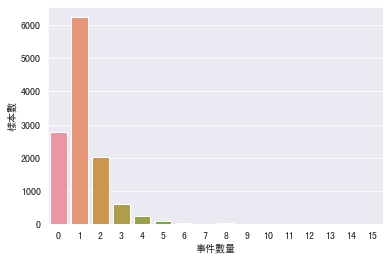

In [13]:
event_counter = Counter()
for event_sent_data in train_list:
    event_counter[len(event_sent_data.get('event_list', []))] += 1
sns.barplot([k for k, v in event_counter.items()], [v for k, v in event_counter.items()])
plt.gca().set_xlabel('事件數量')
plt.gca().set_ylabel('樣本數')

In [14]:
{
    "id": "0aced076d992d94c108992c09446a3c0",
    "sent_id": "e85ecdfab53e869a83de1b057c81bd89",
    "text": "文 | 财联社 王无畏 近日，安徽证监局公布一则行政处罚公告，三七互娱（002555.SZ）原共同实控人吴绪顺因减持存在违法行为被处以警告，并罚款合计430万元。 公开资料显示，三七互娱注册地位于安徽芜湖，公司于2011年3月在深交所上市，公司最初主要经营汽车塑料燃油箱制造、销售，之后通过两次定增完成对游戏公司——上海三七互娱100%股权的收购，主营业务转向移动游戏和网页游戏的研发、发行和运营等。",
    "event_list": [
        {
            "arguments": [
                {
                    "role": "上市公司",
                    "argument": "三七互娱",
                    "argument_start_index": 31
                },
                {
                    "role": "事件时间",
                    "argument": "2011年3月",
                    "argument_start_index": 106
                },
                {
                    "role": "证券代码",
                    "argument": "002555.SZ",
                    "argument_start_index": 36
                },
                {
                    "role": "环节",
                    "argument": "正式上市"
                }
            ],
            "event_type": "公司上市",
            "trigger": "上市",
            "trigger_start_index": 117
        }
    ]
}

{'id': '0aced076d992d94c108992c09446a3c0',
 'sent_id': 'e85ecdfab53e869a83de1b057c81bd89',
 'text': '文 | 财联社 王无畏 近日，安徽证监局公布一则行政处罚公告，三七互娱（002555.SZ）原共同实控人吴绪顺因减持存在违法行为被处以警告，并罚款合计430万元。 公开资料显示，三七互娱注册地位于安徽芜湖，公司于2011年3月在深交所上市，公司最初主要经营汽车塑料燃油箱制造、销售，之后通过两次定增完成对游戏公司——上海三七互娱100%股权的收购，主营业务转向移动游戏和网页游戏的研发、发行和运营等。',
 'event_list': [{'arguments': [{'role': '上市公司',
     'argument': '三七互娱',
     'argument_start_index': 31},
    {'role': '事件时间', 'argument': '2011年3月', 'argument_start_index': 106},
    {'role': '证券代码', 'argument': '002555.SZ', 'argument_start_index': 36},
    {'role': '环节', 'argument': '正式上市'}],
   'event_type': '公司上市',
   'trigger': '上市',
   'trigger_start_index': 117}]}

In [15]:
event_counter

Counter({1: 6241,
         2: 2019,
         0: 2779,
         3: 611,
         6: 29,
         5: 94,
         4: 241,
         7: 17,
         15: 1,
         8: 21,
         9: 4,
         13: 1,
         10: 9,
         12: 2,
         11: 6,
         14: 1})

Text(0, 0.5, '樣本數')

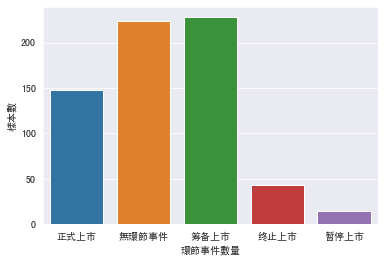

In [16]:
enum_role_counter = Counter()
for event_sent_data in train_list:
    if any([event['event_type'] == "公司上市" for event in event_sent_data.get('event_list', [])]):
        has_enum_role = False
        for event in event_sent_data.get('event_list', []):
            if event['event_type'] == "公司上市":
                check_enum_role = None
                for argument in event['arguments']:
                    if argument["role"] == enum_role:
                        enum_role_counter[argument["argument"]] += 1
                        has_enum_role = True
                        if check_enum_role and check_enum_role != argument["argument"]:
                            print(event_sent_data)
                        check_enum_role = argument["argument"]
        if not has_enum_role:
            enum_role_counter["無環節事件"] += 1 
            
sns.barplot([k for k, v in enum_role_counter.items()], [v for k, v in enum_role_counter.items()])
plt.gca().set_xlabel('環節事件數量')
plt.gca().set_ylabel('樣本數')

In [17]:
enum_role_counter

Counter({'正式上市': 148, '無環節事件': 224, '筹备上市': 228, '终止上市': 43, '暂停上市': 15})

In [18]:
import math
nums = [type_count for type_count in enum_role_counter.values()]
max_ = max(nums)
print([(num / sum(nums)) for num in nums])
itfs = [1.0 / (num / max_) for num in nums]
inverse_distribution = [itf / sum(itfs) for itf in itfs]
print(inverse_distribution)

[0.22492401215805471, 0.3404255319148936, 0.3465045592705167, 0.06534954407294832, 0.022796352583586626]
[0.0640271916844139, 0.04230368022005919, 0.041561510391637094, 0.22037265975100598, 0.6317349579528838]


In [19]:
from operator import itemgetter

In [20]:
event_type_counter = Counter()

for event_sent_data in train_list:
    for event in event_sent_data.get('event_list', []):
        event_type_counter[event['event_type']] += 1
event_type_count = sorted(event_type_counter.items(), key=itemgetter(0), reverse=True)
event_type_count

[('高管变动', 1210),
 ('质押', 1836),
 ('解除质押', 1173),
 ('被约谈', 223),
 ('股份回购', 1943),
 ('股东增持', 474),
 ('股东减持', 1564),
 ('公司上市', 712),
 ('企业融资', 730),
 ('企业破产', 338),
 ('企业收购', 1393),
 ('亏损', 1409),
 ('中标', 1260)]

In [21]:
import math
nums = [type_count[1] for type_count in event_type_count]
total = max(nums)
itfs = [1.0 / (num / total) for num in nums]
inverse_distribution = [itf / sum(itfs) for itf in itfs]
print(inverse_distribution)

[0.04610354260661958, 0.030384143003273245, 0.047557789048601605, 0.25015823566820483, 0.028710904042207764, 0.11769047796204576, 0.03566834178645121, 0.07835012156462035, 0.07641820075891738, 0.16504522649115294, 0.04004686759081815, 0.03959211252946039, 0.04427403694762673]


In [22]:
role_counter = Counter()
for event_sent_data in train_list:
    for event in event_sent_data.get('event_list', []):
        event_type = event['event_type']
        for argument in event['arguments']:
            role_counter[event_type+"("+argument["role"]+")"] += 1
role_counter = {x: count for x, count in role_counter.items() if count < 900}
sorted(role_counter.items(), key=itemgetter(0))

[('中标(中标日期)', 585),
 ('中标(中标金额)', 601),
 ('中标(披露日期)', 568),
 ('中标(招标方)', 732),
 ('亏损(亏损变化)', 558),
 ('亏损(披露时间)', 760),
 ('企业收购(交易金额)', 475),
 ('企业收购(披露时间)', 503),
 ('企业收购(收购完成时间)', 262),
 ('企业收购(收购标的)', 544),
 ('企业破产(债务规模)', 55),
 ('企业破产(债权人)', 40),
 ('企业破产(披露时间)', 137),
 ('企业破产(破产公司)', 289),
 ('企业破产(破产时间)', 115),
 ('企业融资(事件时间)', 197),
 ('企业融资(投资方)', 743),
 ('企业融资(披露时间)', 287),
 ('企业融资(融资轮次)', 260),
 ('企业融资(融资金额)', 456),
 ('企业融资(被投资方)', 638),
 ('企业融资(领投方)', 167),
 ('公司上市(上市公司)', 639),
 ('公司上市(事件时间)', 310),
 ('公司上市(募资金额)', 80),
 ('公司上市(发行价格)', 66),
 ('公司上市(市值)', 35),
 ('公司上市(披露时间)', 206),
 ('公司上市(环节)', 434),
 ('公司上市(证券代码)', 93),
 ('股东减持(交易完成时间)', 616),
 ('股东减持(交易股票/股份数量)', 600),
 ('股东减持(交易金额)', 164),
 ('股东减持(减持部分占总股本比例)', 611),
 ('股东减持(减持部分占所持比例)', 20),
 ('股东减持(披露时间)', 697),
 ('股东减持(每股交易价格)', 44),
 ('股东增持(交易完成时间)', 254),
 ('股东增持(交易股票/股份数量)', 195),
 ('股东增持(交易金额)', 161),
 ('股东增持(增持方)', 445),
 ('股东增持(增持部分占总股本比例)', 95),
 ('股东增持(增持部分占所持比例)', 1),
 ('股东增持(披露时间)', 187),
 ('股东增持(每股交易价格)', 76),
 

In [23]:
import math
nums = [0, 0]
for event_num, count in event_counter.items():
    if event_num == 0:
        nums[0] += count
    else:
        nums[1] += count
total = max(nums)
itfs = [1.0 / (num / total) for num in nums]
inverse_distribution = [itf / sum(itfs) for itf in itfs]
print(inverse_distribution)

[0.7698741305067904, 0.23012586949320968]


In [24]:
import numpy as np

new_train_list = []
for event_sent_data in train_list:
    if event_sent_data.get('event_list', []):
        new_train_list.append(event_sent_data)
    else:
        new_train_list.append(event_sent_data)

In [25]:
new_dev_list = []
for event_sent_data in dev_list:
    new_dev_list.append(event_sent_data)

In [26]:
len(new_train_list), len(new_dev_list)

(12076, 1946)

Text(0, 0.5, '樣本數')

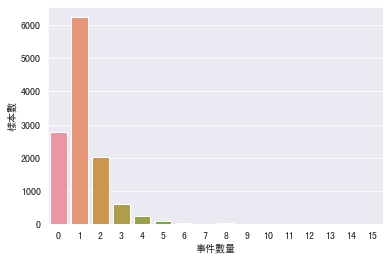

In [27]:
balanced_event_counter = Counter()
for event_sent_data in new_train_list:
    balanced_event_counter[len(event_sent_data.get('event_list', []))] += 1
sns.barplot([k for k, v in balanced_event_counter.items()], [v for k, v in balanced_event_counter.items()])
plt.gca().set_xlabel('事件數量')
plt.gca().set_ylabel('樣本數')

In [28]:
seq_lens = []
for event_sent_data in new_train_list:
    seq_lens.append(len(event_sent_data['text']))
for event_sent_data in new_dev_list:
    seq_lens.append(len(event_sent_data['text']))
print(max(seq_lens))

914


In [29]:
with open('./resources/dataset/duee_fin_train_preprocess.json', 'w', encoding='utf-8') as f:
    json.dump(new_train_list, f, ensure_ascii=False, indent=4)

In [30]:
with open('./resources/dataset/duee_fin_dev_preprocess.json', 'w', encoding='utf-8') as f:
    json.dump(new_dev_list, f, ensure_ascii=False, indent=4)

In [31]:
with open('./resources/dataset/duee_fin_test_preprocess.json', 'w', encoding='utf-8') as f:
    json.dump(test_list, f, ensure_ascii=False, indent=4)

In [32]:
with open('./resources/dataset/duee_fin_test2_preprocess.json', 'w', encoding='utf-8') as f:
    json.dump(test2_list, f, ensure_ascii=False, indent=4)

In [33]:
for event_sent_data in new_train_list:
    emern_tuples = []
    for event in event_sent_data.get('event_list', []):
        for argument in event['arguments']:
            tuple_ = (argument['role'], argument['argument'])
            if argument["role"] == enum_role and tuple_ not in emern_tuples:
                emern_tuples.append(tuple_)
    if len(emern_tuples) > 1:
        print(event_sent_data) 

{'id': 'd245e9090b8457cf4cd5559dfa0640d5', 'sent_id': '9205708a7372d58ba5307d74cb7cef66', 'text': '外媒：阿里拟11月再次赴港上市，至多筹集150亿美元原标题：外媒：阿里拟11月再次赴港上市，至多筹集150亿美元\n 来源：观察者网 10月31日，路透社报道称阿里巴巴将在11月在港交所上市，预计筹集金额100亿至150亿美元。知情人士称，阿里巴巴预计在双十一购物节结束后的11月底或12月初在港交所进行上市。对此，阿里方面对观察者网回应，对市场传闻不予置评。该知情人士还称，考虑到公司规模巨大、投资者对其已经非常熟悉，阿里预计将放弃上市前的路演会议，即在上市前与机构投资者会面。阿里巴巴原计划是8月在港交所上市，但由于某些原因推迟到11月。如果阿里巴巴此次在港交所成功上市，将成为港交所历史上最大的IPO交易案。阿里巴巴于2014年9月19日登陆纽交所，发行价68美元/股，不计超额认购行权，IPO募资200亿美元，创美股史上最高IPO融资记录。在此之前，阿里曾在2013年有意在港交所上市，但最终因其同股不同权的股权结构与港交所机制不符，转赴美国上市。', 'event_list': [{'arguments': [{'role': '披露时间', 'argument': '10月31日', 'argument_start_index': 66}, {'role': '上市公司', 'argument': '阿里巴巴', 'argument_start_index': 79}, {'role': '事件时间', 'argument': '11月', 'argument_start_index': 6}, {'role': '募资金额', 'argument': '100亿至150亿美元', 'argument_start_index': 101}, {'role': '环节', 'argument': '筹备上市'}], 'event_type': '公司上市', 'trigger': '上市', 'trigger_start_index': 13}, {'arguments': [{'role': '上市公司', 'argument': '阿里巴巴', 'argument_st

In [34]:
dev_full_data_list = []
with open('./resources/duee_fin_train.json', 'r', encoding='utf-8') as f:
    for line in f:
        json_data = json.loads(line)
        dev_full_data_list.append(json_data)

mapping_data = {}
for event_sent_data in new_train_list:
    id_ = event_sent_data['id']
    role_list = []
    for event in event_sent_data.get('event_list', []):
        event_type = event['event_type']
        for argument in event['arguments']:
            role_list.append((argument["role"], argument["argument"]))
    if id_ not in mapping_data:
        mapping_data[id_] = []
    mapping_data[id_].extend(role_list)

for d_json in dev_full_data_list:
    id_ = d_json['id']
    true_role_list = []
    for event in d_json.get('event_list', []):
        for argument in event['arguments']:
            true_role_list.append((argument["role"], argument["argument"].replace("\n", "")))
    if len(set(true_role_list)) != len(set(mapping_data[id_])):
        print(id_)
        print(set(true_role_list))
        print(set(mapping_data[id_]))

94aa823be983a3e02fb35cdc8a79621a
{('环节', '正式上市'), ('收购标的', '机车业务'), ('被收购方', '福斯罗集团'), ('上市公司', '福斯罗集团'), ('披露时间', '8月26日'), ('收购方', '中车株洲电力机车有限公司')}
{('收购标的', '机车业务'), ('被收购方', '福斯罗集团'), ('上市公司', '福斯罗集团'), ('披露时间', '8月26日'), ('收购方', '中车株洲电力机车有限公司')}


In [35]:
mapping_data = {}
for event_sent_data in new_train_list:
    id_ = event_sent_data['id']
    trigger_list = []
    for event in event_sent_data.get('event_list', []):
        event_type = event['event_type']
        trigger = event['trigger']
        trigger_list.append((event_type, trigger))
    if id_ not in mapping_data:
        mapping_data[id_] = []
    mapping_data[id_].extend(trigger_list)

for d_json in dev_full_data_list:
    id_ = d_json['id']
    true_trigger_list = []
    for event in d_json.get('event_list', []):
        true_trigger_list.append((event['event_type'], event['trigger']))

    if len(set(true_trigger_list)) != len(set(mapping_data[id_])):
        print(id_)
        print(set(true_role_list))
        print(set(mapping_data[id_]))